# 使用 GDAL 读取 Geotif 

普通的 tif 图像并不带有地理信息，而 geotif 的文件编码了一些投影坐标的信息，可以被 Arcgis 等软件按位置加载。

## GDAL 的安装 

最简单的方式是：
```
conda install gdal
```
它会将 gdal 和 osgeo 正确安装，每种操作系统都很好用。千万不要用 `pip install` 和 binary 的包，会出各种错误。

## 读取Geotif

从 inria 数据集中选取了美国 austin 的一幅影像：

In [1]:
img_path = 'GeotifGDAL_images/austin1.tif'

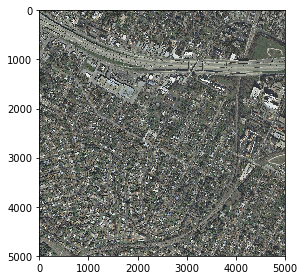

In [2]:
%matplotlib inline
from skimage.io import imshow,imread

img_tif = imread(img_path)
imshow(img_tif)

如果是 以 Geotif 的形式读取进来，是这样：

In [3]:
import gdal
from osgeo import osr

img = gdal.Open(img_path)

图像的尺寸为：

In [4]:
img_height = img.RasterYSize #行数
img_width = img.RasterXSize #列数
img_height,img_width

(5000, 5000)

影像的六个坐标转换参数为：

In [5]:
img_geo_transform = img.GetGeoTransform()
img_geo_transform

(616500.0, 0.29999999999997673, 0.0, 3345000.0, 0.0, -0.30000000000009314)

其中的img_geo_transform[0]、img_geo_transform[3]为图像的左上角投影坐标:

In [6]:
img_geo_transform[0],img_geo_transform[3]

(616500.0, 3345000.0)

有了原始的坐标系和起始坐标，可以把图像左上角的像素点转化为经纬度地理坐标。 WGS-84坐标的 EPSG 编号为4326，可以定义转换的函数：

In [7]:
def get_top_left_corner_latlng(dataset):
    """
    Given a GDAL dataset, computes lat/lng of its top left corner.
    """

    wgs84_spatial_reference = osr.SpatialReference()
    wgs84_spatial_reference.ImportFromEPSG(4326)

    dataset_spatial_reference = osr.SpatialReference()
    dataset_spatial_reference.ImportFromWkt(dataset.GetProjection())

    dataset_to_wgs84 = osr.CoordinateTransformation(dataset_spatial_reference, wgs84_spatial_reference)
    

    geo_transform = dataset.GetGeoTransform()

    x_geo = geo_transform[0]
    y_geo = geo_transform[3] 
    lng, lat, _ = dataset_to_wgs84.TransformPoint(x_geo, y_geo)
    
    return lat, lng

In [8]:
get_top_left_corner_latlng(img)

(30.230979743558063, -97.78932241852807)

可以在谷歌地图上直接使用经纬度查询坐标位置，进一步验证转换的正确性：

![](GeotifGDAL_images/austin_google_map.png)

可以看到左上角的谷歌地上的地标还是比较一致的。